In [1]:
import torch
import os
import pickle as pkl
from tqdm import tqdm
import sys
sys.path.append("/Users/simon.gutwein/src/MICCAI/CellClass")
import CellClass
import matplotlib.pyplot as plt

In [2]:
root = "/Volumes/Custom/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/results/patches"

positives = [os.path.join(root, im) for im in os.listdir(root) if "S19_" in im][11:12]
negatives = [os.path.join(root, im) for im in os.listdir(root) if "S29_" in im][:1]

len(positives), len(negatives)

(1, 1)

In [3]:
dat = []
for patch in tqdm(positives):
    with open(patch, "rb") as fin:
        dat.extend(pkl.load(fin))
pos = len(dat)


for patch in tqdm(negatives):
    with open(patch, "rb") as fin:
        dat.extend(pkl.load(fin))   
neg = len(dat)-pos

pos, neg

100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


(294, 367)

In [4]:
import numpy as np
target = np.concatenate([np.ones(pos), np.zeros(neg)])
target.shape

(661,)

In [5]:
def normalize(patch):

    rgb = patch.RGB
    mask = patch.mask
    rgb[~mask] = 0
    for i in range(3):
        rgb[..., i] = (rgb[..., i] - rgb[..., i].min())/(rgb[..., i].max()-rgb[..., i].min())
    return rgb.transpose(2,0,1)

In [6]:
patches = []
for patch in dat:
    patches.append(normalize(patch))


import random

c = list(zip(patches, target))
random.shuffle(c)
patches, target = zip(*c)

In [7]:
from torch import nn

data_shape = patches[0].shape

def downsampling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
    )

def make_encoder(data_shape, latent_space_size):
    in_channels = data_shape[0]
    shape_at_bottleneck = data_shape[1] // 16, data_shape[2] // 16
    size_at_bottleneck = shape_at_bottleneck[0] * shape_at_bottleneck[1] * 48
    return nn.Sequential(
        downsampling_block(in_channels, 48),    # Block 1 (input)
        downsampling_block(48, 96),             # Block 2
        downsampling_block(96, 192),            # Block 3
        downsampling_block(192, 48),            # Block 4 (limits number of channels to reduce total number of parameters)
        nn.Flatten(),                           # Flatten before FC-layer at the bottleneck
        nn.Linear(size_at_bottleneck, latent_space_size),   # Bottleneck
    )

# Now let's build our encoder, with an arbitrary dimensionality of the latent space
# and an input size depending on the data.
latent_space_size = 32
encoder = make_encoder(data_shape, latent_space_size*2)

In [8]:
from torchinfo import summary
summary(encoder)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,344
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       20,784
│    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       41,568
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       83,040
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-9                       166,080
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      331,968
│    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-13                      82,992
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      20,784
│    └─ReLU: 2-16                     

In [9]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view((-1, *self.shape))

# Same building blocks for the decoder as for the encoder
def upsampling_block(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
    )

def make_decoder(data_shape, latent_space_size):
    out_channels = data_shape[0]
    shape_at_bottleneck = data_shape[1] // 16, data_shape[2] // 16
    size_at_bottleneck = shape_at_bottleneck[0] * shape_at_bottleneck[1] * 48
    return nn.Sequential(
        # Bottleneck
        nn.Linear(latent_space_size, size_at_bottleneck),
        nn.ReLU(),
        Reshape((48, *shape_at_bottleneck)),    # Restore shape before convolutional layers

        upsampling_block(48, 192),     # Block 1
        upsampling_block(192, 96),     # Block 2
        upsampling_block(96, 48),      # Block 3
        nn.ConvTranspose2d(in_channels=48, out_channels=48, kernel_size=2, stride=2), # Block 4 (output)
        nn.ReLU(),
        nn.Conv2d(in_channels=48, out_channels=out_channels, kernel_size=3, padding=1),
    )

# Now let's build our decoder, with the dimensionality of the latent space matching that of the encoder
# and an output size depending on the data.
decoder = make_decoder(data_shape, latent_space_size)

In [24]:
import torch
import torchmetrics
import torch.nn.functional as F

def kl_div(mu, logvar):
    kl_div_by_samples = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kl_div_by_samples)

def vae_forward_pass(encoder, decoder, x):
    """VAE forward pass.

    Args:
        encoder: neural net that predicts a mean and a logvar vector
        decoder: neural net that projects a point in the latent space back into the image space
        x: batch of N ACDC segmentation maps

    Returns:
        loss: crossentropy + kl_divergence loss
        x_hat: batch of N reconstructed segmentation maps
    """
    # We don't need to flatten the input images to (N, num_pixels) anymore,
    # but we need to convert them from one-channel categorical data to multi-channel one-hot format
    #encoder_input = torchmetrics.utilities.data.to_onehot(x, num_classes=4).float()

    encoding_distr = encoder(x)  # Forward pass on the encoder (to get the latent space posterior)

    # We use the same trick as before to easily extract the components of the posterior distribution (mean and logvar latent vectors)
    mu, logvar = encoding_distr[:, :latent_space_size], encoding_distr[:, latent_space_size:]

    # Reparametrization trick
    # (same as before, since the latent codes are vectors regardless of input data's structure)
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Similar to the input that we didn't need to vectorize, we don't need to reshape the output to a 2D shape anymore,
    # since the convolutional network already produces a structured output
    x_hat = decoder(z)  # Forward pass on the decoder (to get the reconstructed input)
    loss = F.mse_loss(x_hat, x) # Compute the reconstruction loss
    loss += 1e-4 * kl_div(mu, logvar)  # Loss now also includes the KL divergence term
    return loss, x_hat # Transform segmentation back to categorical so that it can be displayed easily

In [29]:
import os
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# Define some training hyperparameters
epochs = 10
batch_size = 8

def train(forward_pass_fn, encoder, decoder, optimizer, train_data, val_data, device="cpu"):
    # Create dataloaders from the data
    # Those are PyTorch's abstraction to help iterate over the data
    data_loader_kwargs = {"batch_size": batch_size, "num_workers": os.cpu_count() - 1, "pin_memory": True}
    train_dataloader = DataLoader(train_data, shuffle=True, **data_loader_kwargs)
    val_dataloader = DataLoader(val_data, **data_loader_kwargs)

    fit_pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    pbar_metrics = {"train_loss": None, "val_loss": None}
    for epoch in fit_pbar:
        # Set model in training mode before training

        # Train once over all the training data
        for y in train_dataloader:
            print(y.shape)
            y = y.to(device)    # Move the data tensor to the device
            optimizer.zero_grad()   # Make sure gradients are reset
            train_loss, _ = forward_pass_fn(encoder, decoder, y)    # Forward pass+loss
            train_loss.backward()   # Backward pass
            optimizer.step()    # Update parameters w.r.t. optimizer and gradients
            pbar_metrics["train_loss"] = train_loss.item()
            fit_pbar.set_postfix(pbar_metrics)

        # At the end of the epoch, check performance against the validation data
        for y in val_dataloader:
            y = y.to(device)    # Move the data tensor to the device
            val_loss, _ = forward_pass_fn(encoder, decoder, y)
            pbar_metrics["val_loss"] = val_loss.item()
            fit_pbar.set_postfix(pbar_metrics)

In [30]:
import numpy as np
train_dat = np.array(patches)[:64]
val_dat = np.array(patches)[64:72]

train_dat = torch.tensor(train_dat)
val_dat = torch.tensor(val_dat)

In [31]:
optimizer = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()])
train(vae_forward_pass, encoder, decoder, optimizer, train_dat, val_dat)

Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


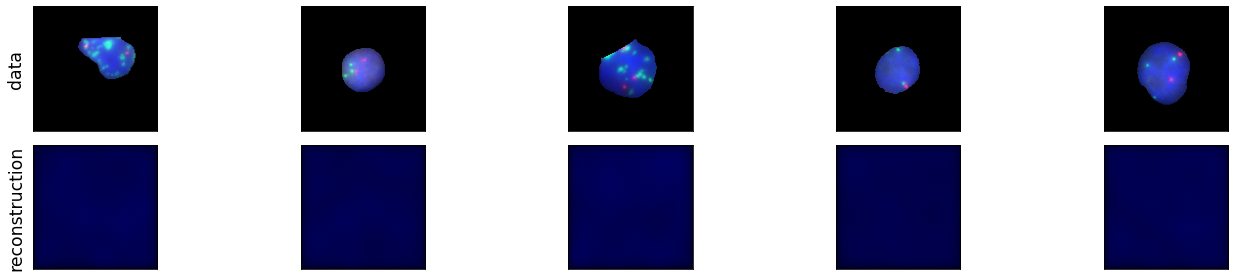

In [ ]:
import sys
sys.path.append("/Users/simon.gutwein/src/deep-learning-tutorials")
from src.visualization import utils
import importlib
importlib.reload(utils)

utils.display_autoencoder_results(val_dat, lambda x: vae_forward_pass(encoder, decoder, x)[1], num_samples=5)

In [ ]:
import sys
sys.path.append("/Users/simon.gutwein/src/deep-learning-tutorials")

im = val_dat

im = torch.tensor(im)

ret = encoder(im)

In [ ]:
ims = decoder(torch.randn(8, 32))

im = ims[0].detach().numpy()

for i in range(3):
    im[i] = (im[i]-im[i].min())/(im[i].max()-im[i].min())

im = im.transpose(1,2,0)

In [ ]:
plt.imshow(im)